# Set up the problem

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import networkx as nx
import numpy as np
import matplotlib
import seaborn as sns
sns.set_style('ticks')
matplotlib.rcParams.update(matplotlib.rc_params_from_file('./matplotlibrc'))
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize']=(15,10)
matplotlib.rcParams['font.size']=30
#matplotlib.rcParams['figure.titlesize']=30
matplotlib.rcParams['font.family']='sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'libertine'
matplotlib.rcParams['text.usetex']=False

from flownetpy import LinearFlowNetwork

In [3]:
import braess_detection

In [4]:
from braess_detection.braess_tools import steady_flows_vector, steady_flows_dict, maxflow_change_on_each_edge_strengthening, AugmentedGraph
import nxdraw_helpers as dr

In [188]:
N = 5
G = nx.grid_2d_graph(N,N)

for u,v in G.edges():
    G[u][v]['weight'] = 1

Gr = AugmentedGraph(G, weight_attr='weight')
I = {i:0 for i in Gr.nodes_ordered()}

pos = {n:n for n in G.nodes()}

# select some sources and some sinks
num_srcs = num_sinks = G.number_of_nodes()//8

np.random.seed(21)  #6
nonboundary_nodes_idx = [idx for (u,v),idx in Gr.nodes2idx.items() if N//8<u<7*N//8 and N//8<v<7*N//8]
src_idxs = np.random.choice(nonboundary_nodes_idx, num_srcs, replace=False)
sink_idxs = np.random.choice(list(set(nonboundary_nodes_idx) - set(src_idxs)), num_sinks, replace=False)

for idx in src_idxs:
    I[Gr.idx2nodes[idx]] = 1
for idx in sink_idxs:
    I[Gr.idx2nodes[idx]] = -1


In [189]:
def compute_maxflow_edge(ag:AugmentedGraph, stflows_dict:dict):
    maxflow_idx = np.argmax(np.abs(list(stflows_dict.values())))
    maxflow_edge = ag.idx2edges[maxflow_idx]
    return stflows_dict[maxflow_edge], maxflow_edge


def src_sink(edge, flows:dict): 
    if flows[edge] > 0:
        src, sink = edge
    else:
        sink, src = edge
    return src, sink

stflows_dict = steady_flows_dict(Gr, inputs=I)
stflows_vec = np.array([stflows_dict[i] for i in Gr.edges_ordered()])
maxflow, maxflow_edge = compute_maxflow_edge(ag=Gr, stflows_dict=stflows_dict)

maxflow_src, maxflow_sink = src_sink(maxflow_edge, stflows_dict)

In [190]:
dF = maxflow_change_on_each_edge_strengthening(Gr, stflows_vec, maxflow_src, maxflow_sink)
dF[maxflow_edge] = 0


be_edges = [e for e,df in dF.items() if df > 0]
nbe_edges = [e for e,df in dF.items() if df < 0]

## We identify edges that can be used to mitigate a damage.

In [191]:
maxflow_src, maxflow_sink

((1, 3), (2, 3))

### choose a non-braessian edge to damage

In [192]:
to_perturb_s, to_perturb_e = nbe_edges[np.random.choice(len(nbe_edges))]
#to_perturb_s, to_perturb_e = Gr.idx2edges[np.argmin(dF)] # most "non-braessian edge"

EPS = 0.1
# check that the new maxflow is indeed higher
H = G.copy()
for u,v in H.edges():
    H[u][v]['weight'] = 1
H[to_perturb_s][to_perturb_e]['weight'] -= EPS

In [193]:
to_perturb_e, to_perturb_s, maxflow_edge

((1, 4), (1, 3), ((1, 3), (2, 3)))

In [194]:
H[to_perturb_e][to_perturb_s]

{'weight': 0.9}

In [195]:
Gr_firstcut = AugmentedGraph(H, weight_attr='weight')
stflows_dict_firstcut = steady_flows_dict(Gr_firstcut, I)
stflows_vec_firstcut = steady_flows_vector(Gr_firstcut, I)

maxflow_firstcut, maxflow_edge_firstcut = compute_maxflow_edge(ag=Gr_firstcut, stflows_dict=stflows_dict_firstcut)
assert maxflow_edge_firstcut == maxflow_edge, "the maximum flow is no longer across the same edge"
assert abs(maxflow_firstcut) > abs(maxflow)

In [196]:
stflows_vec_secondcut - stflows_vec_firstcut

array([ 0.0034322 , -0.0034322 ,  0.00258116, -0.00601336, -0.00167378,
       -0.00433957, -0.00225665, -0.00208292, -0.00208292,  0.00771545,
       -0.00428325,  0.00856621, -0.0102683 , -0.00701964, -0.00492244,
       -0.00546082, -0.00171827, -0.00380119,  0.01114794, -0.00343249,
        0.03098786, -0.02585415, -0.02951016, -0.00336362, -0.00857488,
       -0.00024956, -0.00405075, -0.00525949,  0.01640743, -0.0269264 ,
        0.07432169,  0.02723987,  0.01757166,  0.0047222 ,  0.00427457,
        0.00022382, -0.00525949, -0.03218589, -0.00494602, -0.00022382])

In [14]:
dF_firstcut = maxflow_change_on_each_edge_strengthening(Gr_firstcut, stflows_vec_firstcut, maxflow_src, maxflow_sink)

### What happens now if each breassian edges are damaged as well?

### A bruteforce exact solver

In [197]:
def maxflow_with_noninfinitesimal_delta(G:nx.Graph, edge_to_perturb, deltaK, inputs):
    T = G.copy()
    s,t = edge_to_perturb
    assert 'weight' in T[s][t]
    T[s][t]['weight'] += deltaK

    Gr = AugmentedGraph(T, weight_attr='weight')
    stflows_dict = steady_flows_dict(Gr, inputs)
    
    return max(np.abs([i for i in stflows_dict.values()]))

In [198]:
assert np.isclose(maxflow_with_noninfinitesimal_delta(G, edge_to_perturb=((0,0), (0,1)), deltaK=0, inputs=I), maxflow)

/Users/debsankha.manik/.pyenv/versions/3.8.10/envs/braessrepro/lib/python3.8/site-packages/matplotlib/font_manager.py:1329: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  warnings.warn(


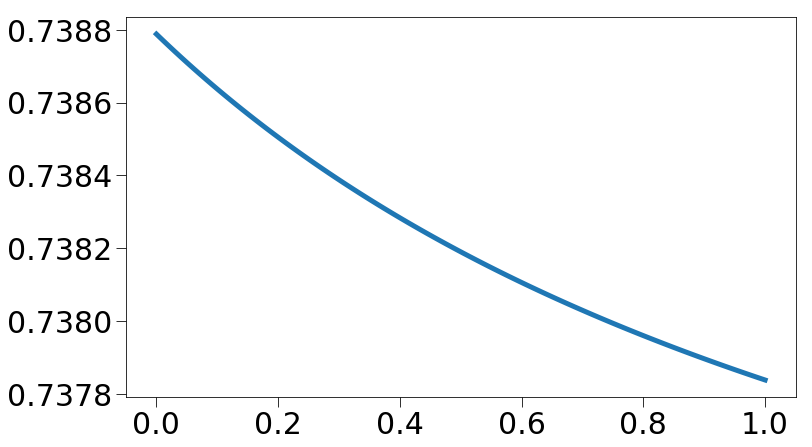

In [199]:
fig, ax = plt.subplots(figsize=(12,7))

x = np.linspace(0,1,100)
y = [maxflow_with_noninfinitesimal_delta(G, edge_to_perturb=((0,0), (0,1)), deltaK=i, inputs=I) for i in x]

ax.plot(x,y)

In [225]:
deltaK_to_mitigate = []
edges_mitigating = []
edges_notmitigating_nonbraess = []
edges_notmitigating_braess = []

orig_abs_maxflow = abs(maxflow)
deltaK_arr = np.linspace(-1,0,100)

for e in Gr_firstcut.edges_ordered():
    if e == maxflow_edge:
        continue
   
    maxflow_arr = np.array([maxflow_with_noninfinitesimal_delta(H, edge_to_perturb=e, deltaK=deltaK, inputs=I) for deltaK in deltaK_arr])
    
    if min(maxflow_arr) < maxflow:
        edges_mitigating.append(e)
        deltaK_needed = deltaK_arr[np.flatnonzero(maxflow_arr < maxflow)[-1]]
        deltaK_to_mitigate.append(-deltaK_needed)
        assert e in be_edges
    else:
        if e in be_edges:
            edges_notmitigating_braess.append(e)
        else:
            edges_notmitigating_nonbraess.append(e)

/Users/debsankha.manik/.pyenv/versions/3.8.10/envs/braessrepro/lib/python3.8/site-packages/matplotlib/font_manager.py:1329: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  warnings.warn(


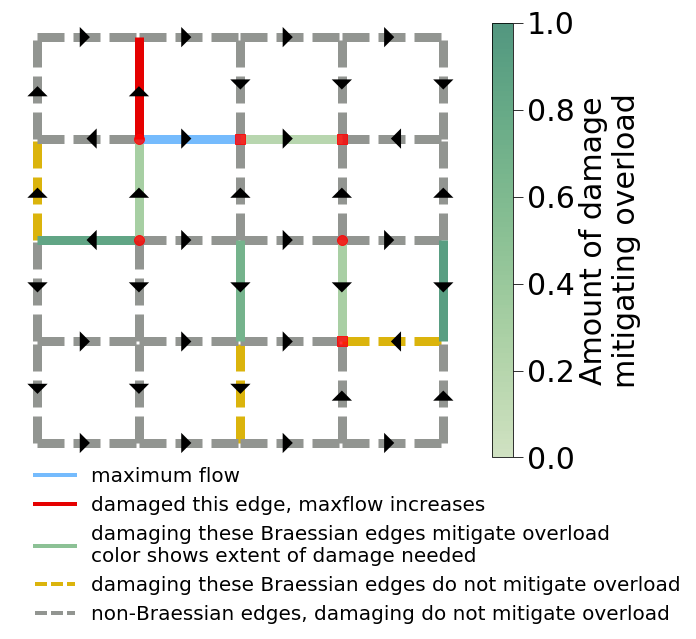

In [245]:
import nxdraw_helpers as dr
fig, ax = plt.subplots(1,1,figsize=(10,10))
#dr.draw_networkx_coloured_by_flow(Gr, F, inputs = I, pos= pos, ax = ax)
dr.draw_networkx_src_and_sink(G, inputs=I, pos=pos, ax=ax)
#flowdict = dr.to_flowdict(F, Gr)
dr.draw_edge_arrowheads(G, pos, stflows_dict, ax)


_edge_width = 9
edge_cmap = sns.cubehelix_palette(start=0, rot=-.5, dark=0.5, as_cmap=True)

# draw non-mitigating edges
dr.draw_networkx_colored_edges(G, edgelist= edges_notmitigating_braess, colors='xkcd:gold', ax=ax, style=(0, (3,1)),
                               pos=pos, with_cbar=False, width=_edge_width)

# draw non-braessian edges
dr.draw_networkx_colored_edges(G, edgelist=edges_notmitigating_nonbraess, colors='xkcd:grey', ax=ax, style=(0, (3,1)),
                               pos=pos, with_cbar=False, width=_edge_width)


# draw how much other edges have to be cut to mitigate
dr.draw_networkx_colored_edges(G, edgelist= edges_mitigating, colors=[i for i in deltaK_to_mitigate], ax=ax,
                               pos=pos, with_cbar=True, vmin=0, vmax=1, width=_edge_width,
                               cmap=edge_cmap, cbar_label='Amount of damage\nmitigating overload',
                               )

# draw maxflow edge
dr.draw_networkx_colored_edges(G, edgelist=[maxflow_edge], colors="xkcd:sky blue",
                               ax=ax, pos=pos, with_cbar=False, width=_edge_width)

# Draw first cut
dr.draw_networkx_colored_edges(G, edgelist=[(to_perturb_s, to_perturb_e)],
                               colors="xkcd:red", ax=ax, pos=pos,
                               with_cbar=False, width=_edge_width)


# draw legends
proxies = [matplotlib.lines.Line2D([0,1], [0], color='xkcd:sky blue', linewidth=4),
           matplotlib.lines.Line2D([0,1], [0], color='xkcd:red', linewidth=4),
           matplotlib.lines.Line2D([0,1], [0], color=edge_cmap.colors[len(edge_cmap.colors)//2], linewidth=4),
           matplotlib.lines.Line2D([0,1], [0], color='xkcd:gold', linewidth=4, linestyle=(0, (3,1))),
           matplotlib.lines.Line2D([0,1], [0], color='xkcd:grey', linewidth=4, linestyle=(0, (3,1))),
          ]

descriptions = [
    'maximum flow', 
    'damaged this edge, maxflow increases', 
    'damaging these Braessian edges mitigate overload\ncolor shows extent of damage needed',  
    'damaging these Braessian edges do not mitigate overload',  
    'non-Braessian edges, damaging do not mitigate overload']

#ax2 = fig.add_axes([0,0, 1, 0.1])
#ax2.axis('off')
ax.legend(proxies, descriptions, numpoints=1, markerscale=2, fontsize=20, loc='lower left', 
          bbox_to_anchor=(0, -0.4), frameon=False
         )
#fig.subplots_adjust(wspace=0.05, hspace=0.4, right=0.8)
#plt.savefig('../manuscript/pics/be-mitigating.pdf', bbox_inches='tight')
#ax.set_title("Damaging  Baressian edge mitigates\noverload due to damaging another edge")
fig.savefig('/Users/debsankha.manik/toy-fighting-braess.pdf', bbox_inches='tight')